<a href="https://colab.research.google.com/github/sarnavadatta/Finance-in-Python/blob/main/StockPricePrediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# data loading
ticker = "HDFCBANK.NS"
start_date = "2018-01-01"
end_date = "2025-06-30"

print(f"Fetching data for {ticker} from {start_date} to {end_date}...")
df = yf.download("HDFCBANK.NS", start=start_date, end=end_date, auto_adjust=True)
df.columns = df.columns.get_level_values(0)

df.head()

Fetching data for HDFCBANK.NS from 2018-01-01 to 2025-06-30...


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,869.462341,881.769371,867.586984,877.995192,3290258
2018-01-02,877.831116,879.073551,871.361169,871.361169,2388158
2018-01-03,868.594971,880.597243,867.915120,879.073516,2265644
2018-01-04,871.994019,874.619507,868.759017,868.759017,1186888
2018-01-05,873.728760,875.815129,869.954638,873.447468,1435434


In [ ]:
# Delete the corresponding rows if df['volume']==0. Also print the corresponding rows.

# Print rows where 'Volume' is 0
print("Rows with Volume == 0:")
print(df[df['Volume'] == 0])

# Delete rows where 'Volume' is 0
df = df[df['Volume'] != 0]

print("\nDataFrame after deleting rows with Volume == 0:")
print(df.head())

Rows with Volume == 0:
Price             Close         High          Low         Open  Volume
Date                                                                  
2025-03-18  1691.788574  1691.788574  1691.788574  1691.788574       0

DataFrame after deleting rows with Volume == 0:
Price            Close        High         Low        Open   Volume
Date                                                               
2018-01-01  869.462341  881.769371  867.586984  877.995192  3290258
2018-01-02  877.831116  879.073551  871.361169  871.361169  2388158
2018-01-03  868.594971  880.597243  867.915120  879.073516  2265644
2018-01-04  871.994019  874.619507  868.759017  868.759017  1186888
2018-01-05  873.728760  875.815129  869.954638  873.447468  1435434


In [ ]:
# Apply log transformation to Volume to stabilize variance
df['Log Volume'] = np.log(df['Volume'])

# deleting the original column of volume
df.drop(columns = ['Volume'], inplace = True)

In [ ]:
# Technical Indicators: RSI
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

In [ ]:
# Technical Indicators: MACD
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2

In [ ]:
# Feature engineering
df['MA12'] = df['Close'].rolling(window=12).mean()
df['MA26'] = df['Close'].rolling(window=26).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

df.dropna(inplace=True)
df.shape

(1649, 11)

In [ ]:
# Select features
features = ['Open', 'High', 'Low', 'Close', 'Log Volume', 'MA12', 'MA26', 'MA50', 'MA200', 'RSI', 'MACD']
# features = ['Open', 'High', 'Low', 'Close', 'Log Volume']
data = df[features].values

In [ ]:
# Normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
pd.DataFrame(scaled_data, columns=features)

,Open,High,Low,Close,Log Volume,MA12,MA26,MA50,MA200,RSI,MACD
0,-1.758151,-1.754166,-1.704224,-1.731433,0.018490,-1.758881,-1.746282,-1.659798,-1.698152,-0.642987,-0.449752
1,-1.701010,-1.735973,-1.704960,-1.717825,-0.094010,-1.754710,-1.747697,-1.665098,-1.696624,-0.529896,-0.410875
2,-1.757045,-1.745529,-1.723641,-1.760946,0.685981,-1.751027,-1.752085,-1.671503,-1.695516,-0.047774,-0.420444
3,-1.765892,-1.794042,-1.748396,-1.774921,-0.367641,-1.747839,-1.754323,-1.677515,-1.694286,-0.213867,-0.439168
4,-1.774556,-1.816553,-1.847417,-1.839096,-0.185064,-1.754161,-1.758862,-1.684708,-1.693487,-0.363581,-0.514270
...,...,...,...,...,...,...,...,...,...,...,...
1644,2.133878,2.114958,2.156572,2.129451,-0.764733,2.164137,2.168202,2.179111,1.858629,0.207894,0.168925
1645,2.198022,2.196241,2.209817,2.177637,0.255308,2.158362,2.171561,2.194809,1.865785,0.149839,0.206881
1646,2.201886,2.207798,2.241842,2.252034,-0.065573,2.158784,2.181441,2.208708,1.873133,0.298868,0.305239
1647,2.261393,2.381534,2.303961,2.412394,1.490734,2.177113,2.195815,2.221280,1.881276,0.450722,0.534423


In [ ]:
# Create sliding window sequences
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i])
        y.append(dataset[i, 3])  # Predicting Close price (index 3)
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_data, time_step)

X.shape, y.shape

((1589, 60, 11), (1589,))

In [ ]:
# Define split lengths
test_size = 30
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['RootMeanSquaredError'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,745 (655.25 KB)

 Trainable params: 167,745 (655.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Early stopping condition
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=8,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - RootMeanSquaredError: 0.3438 - loss: 0.1300 - val_RootMeanSquaredError: 0.3389 - val_loss: 0.1148
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - RootMeanSquaredError: 0.2271 - loss: 0.0519 - val_RootMeanSquaredError: 0.2403 - val_loss: 0.0577
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - RootMeanSquaredError: 0.1991 - loss: 0.0397 - val_RootMeanSquaredError: 0.1910 - val_loss: 0.0365
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - RootMeanSquaredError: 0.1891 - loss: 0.0358 - val_RootMeanSquaredError: 0.1085 - val_loss: 0.0118
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - RootMeanSquaredError: 0.1774 - loss: 0.0316 - val_RootMeanSquaredError: 0.2233 - val_loss: 0.0499
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - RootMeanSquaredError: 0.1709 - loss: 0.0293 - val_RootMeanSquaredError: 0.3210 - val_loss: 0.1031
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - RootMeanSquar

In [ ]:
# Predict and inverse scale
predicted = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)
predicted_full = np.zeros((len(predicted), len(features)))
predicted_full[:, 3] = predicted[:, 0]  # Fill predicted Close in correct index
y_test_full = np.zeros((len(y_test), len(features)))
y_test_full[:, 3] = y_test

predicted_prices = scaler.inverse_transform(predicted_full)[:, 3]
actual_prices = scaler.inverse_transform(y_test_full)[:, 3]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


In [ ]:
# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 16.68
RMSE: 24.36


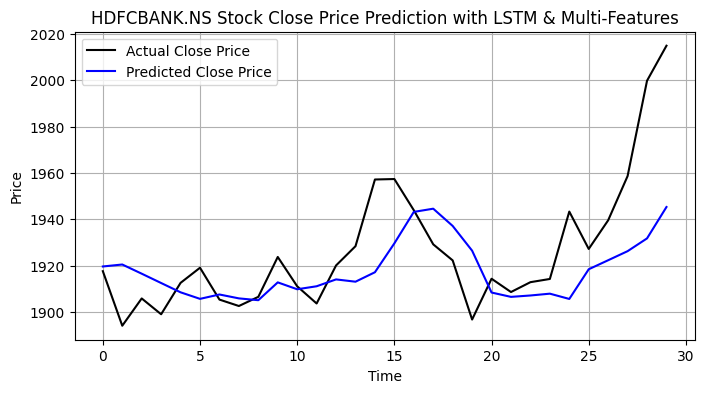

In [ ]:
# 10. Plot predictions
plt.figure(figsize=(8, 4))
plt.plot(actual_prices, label='Actual Close Price', color='black')
plt.plot(predicted_prices, label='Predicted Close Price', color='blue')
plt.title(f'{ticker} Stock Close Price Prediction with LSTM & Multi-Features')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.5568 - val_loss: 0.1012
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.1287 - val_loss: 0.0148
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.1061 - val_loss: 0.0135
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0820 - val_loss: 0.0104
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0746 - val_loss: 0.0727
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0791 - val_loss: 0.0506
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 0.0715 - val_loss: 0.0777
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0686 - val_loss: 0.0156
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0641 - val_loss: 0.0115
Epoch 10/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0677 - val_loss: 0.1330
Epoch 11/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0653 - val_loss: 0.0224
Epoch 12/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step -

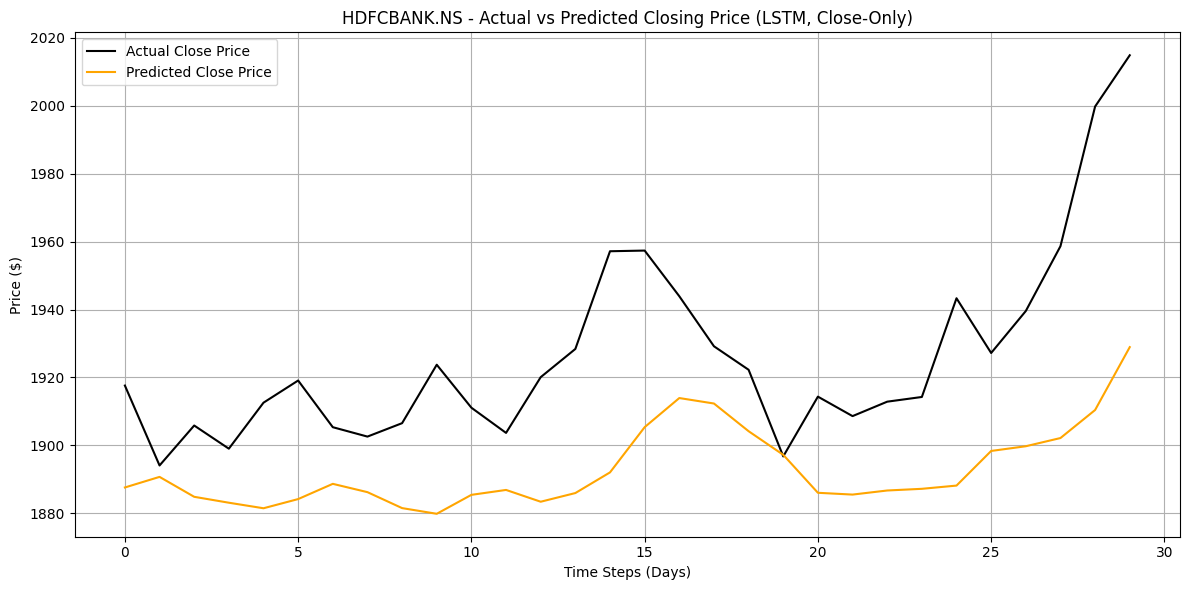

In [ ]:
# Use only 'Close' price
data = df[['Close']].values

# Normalize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(dataset, time_step):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_sequences(scaled_data, time_step)

# Reshape X for LSTM [samples, time_step, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split: last 30 samples as test
test_size = 30
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))

# Predict on test set
y_pred = model.predict(X_test)

# Inverse scale predictions
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Performance metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted Close prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Close Price', color='black')
plt.plot(y_pred_inv, label='Predicted Close Price', color='orange')
plt.title(f'{ticker} - Actual vs Predicted Closing Price (LSTM, Close-Only)')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
